---
# Policy Gradient
---

- episode 가 끝나야 학습이 가능
- episode 의 각 step 의 데이터를 저장해놓아 한번에 업데이트
- DQN 과 다르게 가치기반이 아닌 정책기반 학습 - 더 안정적으로 수렴한다
- 이 case 에서는 3 개의 hidden layer 신경망, 초기화는 모두 평균 0, 분산 0.01 인 정규분포로 하였다
---

In [1]:
import sys

In [2]:
%matplotlib notebook  
import matplotlib
import tensorflow as tf
import gym
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
env = gym.make('CartPole-v1')

In [4]:
size_in = env.observation_space.shape[0]
size_out = env.action_space.n
size_w1 = 8
size_w2 = 12
size_w3 = 6
save_file = 'C:\\Users\\김민수\\Documents\\GitHub\\RL\\vars\\cartpole_pg'

lr = .02 ## learning rate
total_episode = 5000
epsilon = .2
gamma = .95  ##Discounted factor

reward = tf.placeholder(tf.float32)
STATE_IN = tf.placeholder(tf.float32, [None, size_in])
W_1 = tf.Variable(tf.random_normal([size_in, size_w1],stddev=.01), name='W_1')
W_2 = tf.Variable(tf.random_normal([size_w1, size_w2],stddev=.01), name='W_2')
W_3 = tf.Variable(tf.random_normal([size_w2, size_w3],stddev=.01), name='W_3')
out = tf.Variable(tf.random_normal([size_w3, size_out],stddev=.01), name='out')

In [5]:
L_1 = tf.matmul(STATE_IN, W_1)
L_2 = tf.matmul(L_1, W_2)
L_3 = tf.matmul(L_2, W_3)
L_out = tf.sigmoid(tf.matmul(L_3, out))

loss = -tf.reduce_mean(tf.log(L_out)*reward) ##pg는 신경망을 거치면 정책(pi)이 바로 나온다.
train = tf.train.AdamOptimizer(lr).minimize(loss)

In [6]:
def discounted_reward(r):
    dr = np.zeros_like(r)
    sum_r = 0
    
    for i in reversed(range(0, r.size)):
        sum_r = gamma*sum_r + r[i]
        dr[i] = sum_r  
    
    return dr

In [7]:
def make_graph(x, y):
    plt.ion()
    fig = plt.figure()
    sp = fig.add_subplot(111)
    plt.xlim([0, 2000])
    plt.ylim([0, 2000])
    line, = plt.plot(x, y, 'b')
    sp.set_xlabel('episode')
    sp.set_ylabel('reward')
    return fig, sp, line

<IPython.core.display.Javascript object>


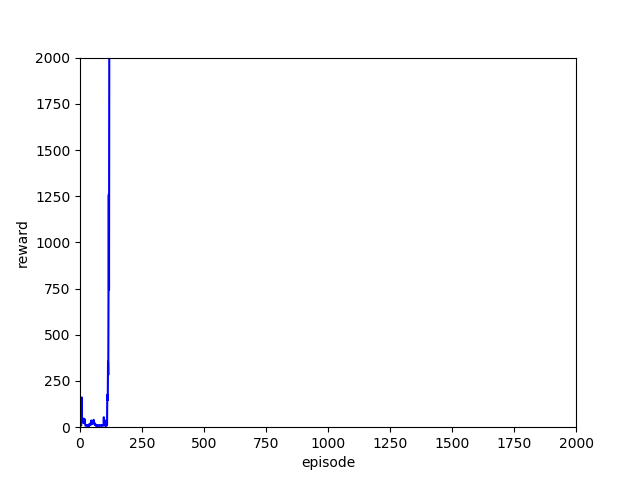

평균 : 9.6
평균 : 75.32000000000001
평균 : 49.864
평균 : 42.5728
평균 : 18.71456
평균 : 13.142912
평균 : 12.2285824
평균 : 14.445716479999998
평균 : 21.689143296
평균 : 24.3378286592
평균 : 33.06756573184
평균 : 27.213513146368
평균 : 18.0427026292736
평균 : 14.008540525854722
평균 : 11.001708105170945
평균 : 11.60034162103419
평균 : 11.520068324206838
평균 : 12.104013664841368
평균 : 12.220802732968274
평균 : 32.244160546593655
평균 : 15.648832109318732
평균 : 45.329766421863745
평균 : 348.06595328437277
평균 : 1669.8131906568747


In [8]:
saver = tf.train.Saver()

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    state_buffer = []
    reward_buffer = []
    step = 0
    ep = 0
    state = env.reset()
    mean_reward = 0
    is_over = False
    
    # 그래프 생성
    x_data = []
    y_data = []
    fig, sp, line = make_graph(x_data, y_data)

    while not is_over:
        done = False
        
        while not done:
            #env.render()            
            step += 1
            state = np.reshape(state, [1, size_in])
            state_buffer.append(state) ##상태 정보 stack
            
            pi = sess.run(L_out, feed_dict={STATE_IN:state})
            if(random.random() < epsilon):
                action = env.action_space.sample()
            else:
                action = np.argmax(pi)
                
            new_state, r, d, _ = env.step(action)
            state = new_state
            reward_buffer.append(r) ##보상 정보 stack
            
            if d:
                ep += 1
                epsilon = 1/(ep/100 + 10)
                
                eps = np.vstack(state_buffer)
                epr = np.vstack(reward_buffer)
                epr = discounted_reward(epr)##데이터 정리
                
                state_buffer, reward_buffer = [], []                
                sess.run(train, feed_dict={STATE_IN:eps, reward:epr})##학습
                mean_reward += step
                #################################학습 정보 쌓기
                
                # 그래프 그리기
                x_data.append(ep)
                y_data.append(step)

                line.set_xdata(x_data)
                line.set_ydata(y_data)
                fig.canvas.draw()
                
                
                if(ep % 5 == 0):
                    mean_reward = mean_reward/5
                    #epsilon = 1 / (mean_reward/100 + ep/100 + 2)
                    print('평균 : {}'.format(mean_reward))
                    
                    if(step >= 2000):
                        mean_reward = 0
                        saver.save(sess, save_file)
                        is_over = True
                        
                step = 0
                done = True
                state = env.reset()
env.close()

In [12]:
saver = tf.train.Saver()

with tf.Session() as sess:
    ep = 0
    step = 0
    state = env.reset()
    saver.restore(sess, save_file)
    
    while True:
        
        done = False
        
        while not done:
            env.render()
            step += 1
            state = np.reshape(state, [1, size_in])
            pi = sess.run(L_out, feed_dict={STATE_IN:state})
            action = np.argmax(pi)
            new_state, r, d, _ = env.step(action)
            state = new_state
            
            if d:
                ep += 1
                print(ep, step)
                step = 0
                done = True
                state = env.reset()
env.close()

INFO:tensorflow:Restoring parameters from C:\Users\itfor\Desktop\모아두기\3학년 2학기\3학년 2학기\기계정보공학특강\프로젝트\save
1 2000
2 2000
3 2000
4 2000
5 2000
6 2000
7 2000
8 2000
9 2000
10 2000
11 2000
12 2000
13 2000
14 2000
15 2000
16 2000
17 2000
18 2000
19 2000
20 2000
21 2000
22 2000
23 2000
24 2000
25 2000
26 2000
27 2000
28 2000
29 2000
30 2000
31 2000
32 2000
33 2000
34 2000
35 2000
36 2000
37 2000
38 2000
39 2000
40 2000
41 2000
42 2000
43 2000
44 2000
45 2000
46 2000
47 2000
48 2000
49 2000
50 2000
51 2000
52 2000
53 2000
54 2000
55 2000
56 2000
57 2000
58 2000
59 2000
60 2000
61 2000
62 2000
63 2000
64 2000
65 2000
66 2000
67 2000
68 2000
69 2000
70 2000
71 2000
72 2000
73 2000
74 2000
75 2000
76 2000
77 2000
78 2000
79 2000
80 2000
81 2000
82 2000
83 2000
84 2000
85 2000
86 2000
87 2000
88 2000
89 2000
90 2000


KeyboardInterrupt: 